In [1]:
# Setup

import numpy as np

# Ein Zufalls-Seed für Reproduzierbarkeit
np.random.seed(42)

from datetime import datetime
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, utils

from IPython.display import display, clear_output

sns.set_theme()

print(f"GPUs für die Berechnung: {len(tf.config.experimental.list_physical_devices('GPU'))}")

/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nico/anaconda3/envs/tensorflow/lib

GPUs für die Berechnung: 0


/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nico/anaconda

In [2]:
# OTU Metadaten einlesen
df = pd.read_csv("NIHMS841832-supplement-1.csv", sep=',')

# Ergebnisse des Feature Tables einlesen
feature = pd.read_csv('feature_table_otu.txt', sep='\t').T
feature = feature[1:][:-1]

In [3]:
# Gesunde Kontrollgruppe
HC = df[df.ibd_subtype.eq("HC")]

y = []
for row in feature.index:
    if any(True for val in HC['sample_name'] if val == row):
        y.append(1)
    else:
        y.append(0)

X = feature.iloc[:, :].values

In [4]:
feature.head()

,0,1,2,3,4,5,6,7,8,9,...,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110
1629.SubjectIBD335,34292.0,20670.0,18413.0,9981.0,7071.0,6881.0,5411.0,5335.0,5289.0,4741.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD643,15243.0,64328.0,0.0,0.0,0.0,4.0,4507.0,3216.0,15630.0,199.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD539,22182.0,21589.0,0.0,1365.0,0.0,11501.0,33619.0,3638.0,5053.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD078,0.0,805.0,0.0,0.0,0.0,4.0,330.0,2305.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD671,0.0,19734.0,0.0,0.0,0.0,0.0,215.0,0.0,0.0,699.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def nn(random_state):
    # Split
    # TODO: Andere Aufteilung
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = random_state)

    # Das Modell soll aufhören zu rechnen, falls es keine nennenswerten Verbesserungen mehr gibt
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001,
        patience=64,
        restore_best_weights=True
    )

    # Das NN besteht aus einer Mischung von Dense-, Normalization- und Dropout-Layern.
    # Dropout führt allem Anschein nach zu schlechterem F1
    # Weniger LUs führen zu besseren Ergebnissen
    network = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
        #layers.Dropout(rate=0.5),
        layers.Dense(64, activation='relu'),
        #layers.Dropout(rate=0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])

    # NN kompilieren
    network.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[keras.metrics.Accuracy()]
    )

    # NN trainieren
    history = network.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=64,
        epochs=512,
        callbacks=[early_stopping],
        verbose=0
    )

    # Scores berechnen
    # history_df = pd.DataFrame(history.history)

    y_pred = np.floor(network.predict(X_test))
    report = sklearn.metrics.classification_report(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    # confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    # print(confusion_matrix)
    # print(report)
    return f1, report, network

    # history_df.loc[5:, ['loss', 'val_loss']].plot()

[[244   4]
 [  8  17]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       248
           1       0.81      0.68      0.74        25

    accuracy                           0.96       273
   macro avg       0.89      0.83      0.86       273
weighted avg       0.95      0.96      0.95       273



(0.8575652173913044,
 '              precision    recall  f1-score   support\n\n           0       0.97      0.98      0.98       248\n           1       0.81      0.68      0.74        25\n\n    accuracy                           0.96       273\n   macro avg       0.89      0.83      0.86       273\nweighted avg       0.95      0.96      0.95       273\n',
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7fa00c9396d0>)

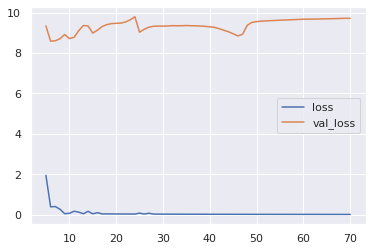

In [11]:
# 100 verschiedene Modelle trainieren und in einen DataFrame speichern
# Das kann ein paar Stunden dauern

results = {}

for i in np.arange(100):
    f1, report, model = nn(i)
    results[i] = [model, f1, report]
    clear_output()
    df_results = pd.DataFrame.from_dict(results, orient='index', columns=['model', 'f1', 'report'])
    display(df_results)


#df_results

In [7]:
# DataFrame nach bestem F1-Score sortieren
df_results_sorted = df_results.sort_values(by=['f1'], ascending=False)

# Die besten 10 Modelle speichern
for i in np.arange(10):
    df_results_sorted.iloc[i].model.save(f'models/best_otu/model{i}.h5')

In [8]:
# Das beste Modell über neue Random-States predicten lassen

for i in np.arange(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = np.random.randint(100000))

    y_pred = np.floor(df_results_sorted.iloc[0].model.predict(X_test))
    report = sklearn.metrics.classification_report(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    print(confusion_matrix)
    print(report)
    print('\n\n\n')

[[253   0]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       253
           1       1.00      0.80      0.89        20

    accuracy                           0.99       273
   macro avg       0.99      0.90      0.94       273
weighted avg       0.99      0.99      0.98       273





[[247   1]
 [  4  21]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       248
           1       0.95      0.84      0.89        25

    accuracy                           0.98       273
   macro avg       0.97      0.92      0.94       273
weighted avg       0.98      0.98      0.98       273





[[247   1]
 [  4  21]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       248
           1       0.95      0.84      0.89        25

    accuracy                           0.98       273
   macro avg       0.97      0.92      0.94       2

[[240   1]
 [  6  26]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       241
           1       0.96      0.81      0.88        32

    accuracy                           0.97       273
   macro avg       0.97      0.90      0.93       273
weighted avg       0.97      0.97      0.97       273





[[242   0]
 [  4  27]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       242
           1       1.00      0.87      0.93        31

    accuracy                           0.99       273
   macro avg       0.99      0.94      0.96       273
weighted avg       0.99      0.99      0.98       273





[[253   0]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       253
           1       1.00      0.75      0.86        20

    accuracy                           0.98       273
   macro avg       0.99      0.88      0.92       2

[[247   1]
 [  3  22]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       248
           1       0.96      0.88      0.92        25

    accuracy                           0.99       273
   macro avg       0.97      0.94      0.95       273
weighted avg       0.99      0.99      0.99       273





[[242   1]
 [  6  24]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       243
           1       0.96      0.80      0.87        30

    accuracy                           0.97       273
   macro avg       0.97      0.90      0.93       273
weighted avg       0.97      0.97      0.97       273







In [9]:
df_results.describe()

,f1
count,100.000000
mean,0.804791
std,0.056015
min,0.643100
25%,0.769900
50%,0.802200
75%,0.845900
max,0.921500
